# Flow Chart Creator 

I saw [this image](images/foul_mood_guide.jpg) and it inspired me to create a flow chart for what to do when you're in a foul mood. So I took a screenshot, submitted it ChatGPT and asked it to create the flow chart. It did pretty well with a few tweaks, but I noticed a lot of repetetion, and defining each node and edge sequentially felt wrong. The the authoring of a flow chart graph did not represent the spirit of the image it was aiming to create. I was further disillusioned by the lack of interactive documentation in the otherwise wonderful [Python implimentation](https://graphviz.readthedocs.io/en/stable/index.html) of Graphviz. Using 'attrs' as keyword argument, forcing the user to lookup attribute names and types, leaves a lot to be desired, especially when working in Jupyter (see Jeremy Howard's thoughts on the matter referenced in my 'delegation' implimentation).

I want to create a generalized, reusable pattern to create flow charts using Graphviz using Pydantic to model, validate, and re-use keyword arguments. And I want the definition of the graph structure to more closely mirror the intended output.

In [ ]:
from graphviz import Digraph, Graph
from typing import * 

Let's start by looking at ChatGPT's solution to creating a flowchart from our source image. 

In [ ]:
def create_foul_mood_flowchart():
    # Initialize the flowchart
    flowchart = Digraph("Foul Mood Guide", format="svg")
    flowchart.attr(rankdir="TB")

    # Add nodes with positioning
    flowchart.node("Start", "Are you hydrated?", pos="0,0!")
    flowchart.node("HydrationYes", "Yes", pos="1,-1!", constraint="false")
    flowchart.node("HydrationNo", "No", pos="-1,-1!", constraint="false")
    flowchart.node("DrinkWater", "If not, have a glass of water.", pos="-2,-2!", constraint="false")

    flowchart.node("Eaten", "Have you eaten in the past 3 hours?", pos="2,-2!")
    flowchart.node("EatenYes", "Yes", pos="3,-3!", constraint="false")
    flowchart.node("EatenNo", "No", pos="1,-3!", constraint="false")
    flowchart.node("EatFood", "If not, get some food with protein, not just carbs.", pos="0,-4!", constraint="false")

    flowchart.node("Showered", "Have you showered in the past day?", pos="4,-4!")
    flowchart.node("ShoweredYes", "Yes", pos="5,-5!", constraint="false")
    flowchart.node("ShoweredNo", "No", pos="3,-5!", constraint="false")
    flowchart.node("TakeShower", "If not, take a shower now.", pos="2,-6!", constraint="false")

    flowchart.node("Stretched", "Have you stretched your legs in the past day?", pos="6,-6!")
    flowchart.node("StretchedYes", "Yes", pos="7,-7!", constraint="false")
    flowchart.node("StretchedNo", "No", pos="5,-7!", constraint="false")
    flowchart.node("DoStretch", "If not, go for a walk or move around.", pos="4,-8!", constraint="false")

    # Add edges with diagonal placement
    flowchart.edge("Start", "HydrationYes", label="Yes", constraint="true")
    flowchart.edge("Start", "HydrationNo", label="No", constraint="true")
    flowchart.edge("HydrationNo", "DrinkWater")
    flowchart.edge("HydrationYes", "Eaten")

    flowchart.edge("Eaten", "EatenYes", label="Yes")
    flowchart.edge("Eaten", "EatenNo", label="No")
    flowchart.edge("EatenNo", "EatFood")
    flowchart.edge("EatenYes", "Showered")

    flowchart.edge("Showered", "ShoweredYes", label="Yes")
    flowchart.edge("Showered", "ShoweredNo", label="No")
    flowchart.edge("ShoweredNo", "TakeShower")
    flowchart.edge("ShoweredYes", "Stretched")

    flowchart.edge("Stretched", "StretchedYes", label="Yes")
    flowchart.edge("Stretched", "StretchedNo", label="No")
    flowchart.edge("StretchedNo", "DoStretch")
    return flowchart

In [ ]:
from IPython.display import SVG

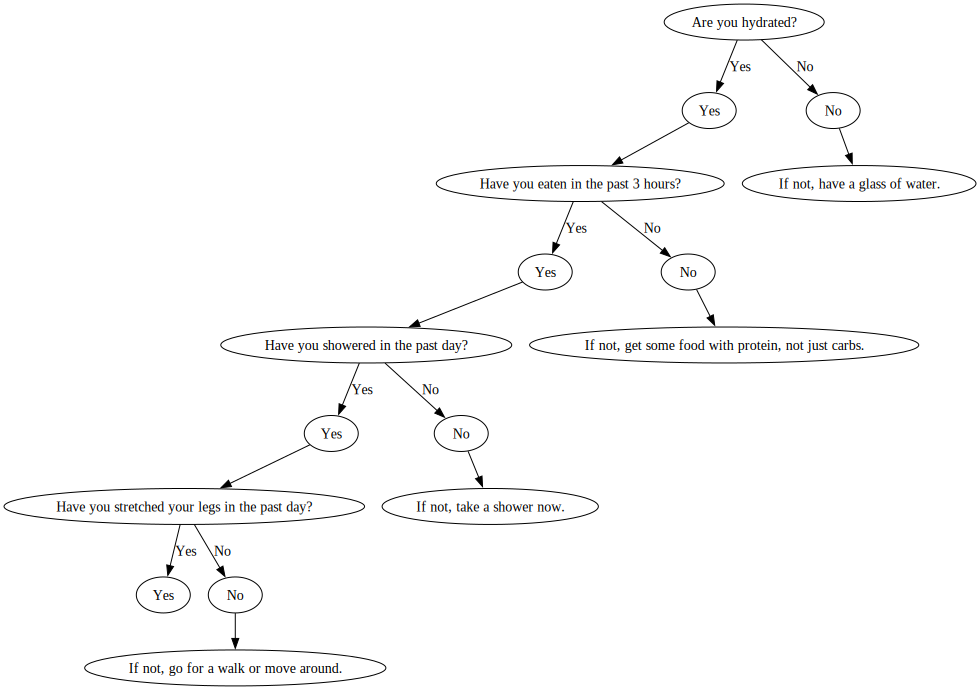

In [ ]:
graph = create_foul_mood_flowchart()
graph.render('images/foulmood_flowchart',format='svg',)
SVG('images/foulmood_flowchart.svg')

In [ ]:
from humble_chuck.models import BaseModel
from pydantic import ConfigDict

Now let's model some of these attributes. Graphviz has 3 primary objects: graphs, nodes, and edges. There are also subgraphs and cluster but let's get to that later. We'll start with the edges. 

But first, let's create a BaseModel that we can use to define common characteristics of our sub-models.

In [ ]:
class GraphVizModel(BaseModel):
    "BaseModel for GraphViz Pydantic models. Used to define common attributes for Graph, Node, and Edge."
    model_config = ConfigDict(repr_kwargs = {'exclude_unset':True})
    
    fontsize: Optional[str] = None
    

In [ ]:
class Edge(GraphVizModel):
    tail_name: str
    head_name: str
    label: Optional[str] = None
    # other edge attributes

Moving on to a NodeModel. 

In [ ]:
class Node(GraphVizModel):
    """Node Model"""
    name: str
    label: str
    pos: Optional[str] = None
    constraint: Optional[bool] = None
    # other attributes for graphviz nodes
    

In [ ]:
class GraphModel(GraphVizModel):
    type: Literal['graph','digraph']
    name: str
    format: Optional[str] = None
    
    nodes: List[Node]
    edges: Optional[List[Edge]] = []

    def make_graph(self):
        graph_kwargs = self.model_dump(exclude={'nodes','edges'}) 
        if self.type == 'graph':
            graph = Graph()
        else:
            graph = Digraph()
        nodes_edges = self.model_dump(include={'nodes','edges'})
        for node in nodes_edges['nodes']:
            graph.node(**node)
        for edge in nodes_edges['edges']:
            graph.edge(**edge)
        return graph

GraphModel(fontsize=None, type='graph', name='basic needs', format=None, nodes=[Node(fontsize=None, name='eaten', label='Have you eaten?', pos=None, constraint=None), Node(fontsize=None, name='eat', label='Eat you idiot!', pos=None, constraint=None), Node(fontsize=None, name='slept', label='Have you slept?', pos=None, constraint=None), Node(fontsize=None, name='sleep', label='Go to bed!', pos=None, constraint=None)], edges=[Edge(fontsize=None, tail_name='eaten', head_name='eat', label='No'), Edge(fontsize=None, tail_name='eaten', head_name='slept', label='Yes'), Edge(fontsize=None, tail_name='slept', head_name='sleep', label=None)])

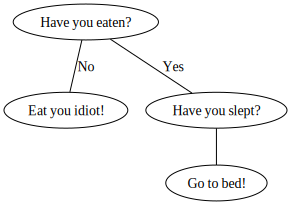

In [ ]:
graph = GraphModel(
    type='graph',
    name='basic needs',
    nodes = [
        Node(name='eaten',label="Have you eaten?",),
        Node(name='eat',label='Eat you idiot!'),
        Node(name='slept',label="Have you slept?"),
        Node(name='sleep',label='Go to bed!')
    ],
    edges = [
        Edge(head_name='eat',tail_name='eaten',label='No'),
        Edge(tail_name='eaten',head_name='slept',label='Yes'),
        Edge(tail_name='slept',head_name='sleep'),
        
        
    ]
)
display(graph)

graph.make_graph()

Not bad, but notice how different the definition and json representation of the graph are from the actual image. I would much prefer a hierarchal way of defining and modeling my basic needs flow chart. I would much rather have something like this:

```
Graph(
    Node(
        name='have you eaten',
        child_nodes={
            'no':Node('eat'),
            'yes':Node(
                name ='have you slept'
                child_nodes={'no':Node('sleep')}
                )
        }
    )
)
```

Something to consider: 

Should we have 'child-nodes' that are able to set their attribute relevant to the parent? I don't see a way of doing this with Graphviz natively. If so, Node would have to be a [self-refrencing model](https://docs.pydantic.dev/latest/concepts/forward_annotations/#self-referencing-or-recursive-models)



### Graphviz Attributes

In [ ]:
import pandas as pd
from pydantic import Field,confloat,ConfigDict
import logging

In [ ]:
#|hide 

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,  # Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Log format
    handlers=[
        logging.StreamHandler(),  # Log to the console
    ]
)

In [ ]:
attributes = pd.read_html("https://graphviz.org/doc/info/attrs.html")[0]
attributes

def normalize_used_by(value):
    as_list = [s.strip() for s in value.split(',')]
    return '|'.join(x for x in sorted(as_list))
    
attributes['Used By'] = attributes['Used By'].apply(
    lambda x: normalize_used_by(x)
)
attributes['Used By'].value_counts()

Used By
Graphs                         74
Edges                          43
Nodes                          18
Clusters|Edges|Graphs|Nodes    13
Clusters|Graphs                 6
Clusters|Edges|Nodes            4
Clusters|Graphs|Nodes           4
Graphs|Nodes                    3
Edges|Nodes                     3
Clusters|Nodes                  2
Edges|Graphs|Nodes              2
Clusters|Subgraphs              1
Clusters|Edges|Graphs           1
Clusters                        1
Subgraphs                       1
Name: count, dtype: int64

In [ ]:
shared_ix = attributes[
    (attributes['Used By']=='Clusters|Edges|Graphs|Nodes')|(attributes['Used By']=='Edges|Graphs|Nodes')
].index
attributes.iloc[shared_ix]

,Name,Used By,Type,Default,Minimum,"Description, notes"
10,class,Clusters|Edges|Graphs|Nodes,string,"""""",NaN,"Classnames to attach to the node, edge, graph,..."
14,colorscheme,Clusters|Edges|Graphs|Nodes,string,"""""",NaN,A color scheme namespace: the context for inte...
15,comment,Edges|Graphs|Nodes,string,"""""",NaN,Comments are inserted into output.
36,fontcolor,Clusters|Edges|Graphs|Nodes,color,black,NaN,Color used for text.
37,fontname,Clusters|Edges|Graphs|Nodes,string,"""Times-Roman""",NaN,Font used for text.
40,fontsize,Clusters|Edges|Graphs|Nodes,double,14.0,1.0,"Font size, in points, used for text."
53,href,Clusters|Edges|Graphs|Nodes,escString,"""""",NaN,"Synonym for URL. map, postscript, svg only."
54,id,Clusters|Edges|Graphs|Nodes,escString,"""""",NaN,"Identifier for graph objects. map, postscript,..."
61,label,Clusters|Edges|Graphs|Nodes,lblString,"""\N"" (nodes) """" (otherwise)",NaN,Text label attached to objects.
100,nojustify,Clusters|Edges|Graphs|Nodes,bool,false,NaN,Whether to justify multiline text vs the previ...


### Base

In [ ]:
class GraphVizBase(BaseModel):
    model_config = ConfigDict(
        populate_by_name=True,
        repr_kwargs = {'exclude_defaults':True}
    )
    name: str 

    def __init__(self,name:str,**kwargs):
        super().__init__(name=name,**kwargs)

### Shared

In [ ]:
class GraphVizAttributesBase(GraphVizBase):
    
    
    class_: Optional[str] = Field(
        default=None,
        alias="class",
        description="Classnames to attach to the node, edge, graph, or cluster's SVG element. (SVG only)",
    )
    colorscheme: Optional[str] = Field(
        default=None,
        description="A color scheme namespace: the context for interpreting color names.",
    )
    comment: Optional[str] = Field(
        default=None,
        description="Comments are inserted into output.",
    )
    fontcolor: Optional[str] = Field(
        default="black",
        description="Color used for text.",
    )
    fontname: Optional[str] = Field(
        default="Times-Roman",
        description="Font used for text.",
    )
    fontsize: Optional[Union[float,str]] = Field(
        default=14.0,
        ge=1.0,
        description="Font size, in points, used for text.",
    )
    href: Optional[str] = Field(
        default=None,
        description="Synonym for URL. (map, postscript, SVG only)",
    )
    id: Optional[str] = Field(
        default=None,
        description="Identifier for graph objects. (map, postscript, SVG only)",
    )
    label: Optional[str] = Field(
        default=None,
        description="Text label attached to objects. Defaults to '\\N' for nodes and empty otherwise.",
    )
    nojustify: Optional[bool] = Field(
        default=False,
        description="Whether to justify multiline text relative to the previous text line (rather than the side of the container).",
    )
    showboxes: Optional[int] = Field(
        default=0,
        ge=0,
        description="Print guide boxes for debugging. (DOT only)",
    )
    style: Optional[str] = Field(
        default=None,
        description="Set style information for components of the graph.",
    )
    target: Optional[str] = Field(
        default=None,
        description="If the object has a URL, this attribute determines which window of the browser is used for the URL. (map, SVG only)",
    )
    tooltip: Optional[str] = Field(
        default=None,
        description="Tooltip (mouse hover text) attached to the node, edge, cluster, or graph. (cmap, SVG only)",
    )
    URL: Optional[str] = Field(
        default=None,
        description="Hyperlinks incorporated into device-dependent output. (map, postscript, SVG only)",
    )



In [ ]:
GraphVizAttributesBase('Name')

name,Name


### Edge Attributes

In [ ]:

attributes[
    (attributes['Used By'].str.contains('Edges'))&(attributes['Used By'].index.isin(shared_ix)==False)
]

,Name,Used By,Type,Default,Minimum,"Description, notes"
2,arrowhead,Edges,arrowType,normal,NaN,Style of arrowhead on the head node of an edge.
3,arrowsize,Edges,double,1.0,0.0,Multiplicative scale factor for arrowheads.
4,arrowtail,Edges,arrowType,normal,NaN,Style of arrowhead on the tail node of an edge.
13,color,Clusters|Edges|Nodes,"color, colorList",black,NaN,"Basic drawing color for graphics, not text."
18,constraint,Edges,bool,true,NaN,"If false, the edge is not used in ranking the ..."
20,decorate,Edges,bool,false,NaN,Whether to connect the edge label to the edge ...
24,dir,Edges,dirType,forward (directed) none (undirected),NaN,Edge type for drawing arrowheads.
28,edgehref,Edges,escString,"""""",NaN,"Synonym for edgeURL. map, svg only."
29,edgetarget,Edges,escString,<none>,NaN,Browser window to use for the edgeURL link. ma...
30,edgetooltip,Edges,escString,"""""",NaN,Tooltip annotation attached to the non-label p...


In [ ]:
class EdgeAttributes(GraphVizAttributesBase):
    arrowhead: Optional[str] = Field(
        default="normal",
        description="Style of arrowhead on the head node of an edge.",
    )
    arrowsize: Optional[Union[float,str]] = Field(
        default=1.0,
        ge=0.0,
        description="Multiplicative scale factor for arrowheads.",
    )
    arrowtail: Optional[str] = Field(
        default="normal",
        description="Style of arrowhead on the tail node of an edge.",
    )
    color: Optional[str] = Field(
        default="black",
        description="Basic drawing color for graphics, not text.",
    )
    constraint: Optional[str] = Field(
        default='True',
        description="If false, the edge is not used in ranking the nodes. (DOT only)",
    )
    decorate: Optional[bool] = Field(
        default=False,
        description="Whether to connect the edge label to the edge with a line.",
    )
    dir: Optional[str] = Field(
        default="forward",
        description="Edge type for drawing arrowheads ('forward', 'none', etc.).",
    )
    edgehref: Optional[str] = Field(
        default=None,
        description="Synonym for edgeURL. (map, SVG only)",
    )
    edgetarget: Optional[str] = Field(
        default=None,
        description="Browser window to use for the edgeURL link. (map, SVG only)",
    )
    edgetooltip: Optional[str] = Field(
        default=None,
        description="Tooltip annotation attached to the non-label part of an edge. (cmap, SVG only)",
    )
    edgeURL: Optional[str] = Field(
        default=None,
        description="The link for the non-label parts of an edge. (map, SVG only)",
    )
    fillcolor: Optional[str] = Field(
        default=None,
        description="Color used to fill the background of a node or cluster.",
    )
    head_lp: Optional[str] = Field(
        default=None,
        description="Center position of an edge’s head label. (Write only)",
    )
    headclip: Optional[bool] = Field(
        default=True,
        description="If true, the head of an edge is clipped to the boundary of the head node.",
    )
    headhref: Optional[str] = Field(
        default=None,
        description="Synonym for headURL. (map, SVG only)",
    )
    headlabel: Optional[str] = Field(
        default=None,
        description="Text label to be placed near head of edge.",
    )
    headport: Optional[str] = Field(
        default="center",
        description="Indicates where on the head node to attach the head of the edge.",
    )
    headtarget: Optional[str] = Field(
        default=None,
        description="Browser window to use for the headURL link. (map, SVG only)",
    )
    headtooltip: Optional[str] = Field(
        default=None,
        description="Tooltip annotation attached to the head of an edge. (cmap, SVG only)",
    )
    headURL: Optional[str] = Field(
        default=None,
        description="If defined, headURL is output as part of the head label of the edge. (map, SVG only)",
    )
    labelangle: Optional[Union[float,str]] = Field(
        default=-25.0,
        ge=-180.0,
        description="The angle (in degrees) in polar coordinates of the head & tail edge labels.",
    )
    labeldistance: Optional[Union[float,str]] = Field(
        default=1.0,
        ge=0.0,
        description="Scaling factor for the distance of headlabel/taillabel from the head/tail nodes.",
    )
    labelfloat: Optional[bool] = Field(
        default=False,
        description="If true, allows edge labels to be less constrained in position.",
    )
    labelfontcolor: Optional[str] = Field(
        default="black",
        description="Color used for headlabel and taillabel.",
    )
    labelfontname: Optional[str] = Field(
        default="Times-Roman",
        description="Font for headlabel and taillabel.",
    )
    labelfontsize: Optional[Union[float,str]] = Field(
        default=14.0,
        ge=1.0,
        description="Font size of headlabel and taillabel.",
    )
    labelhref: Optional[str] = Field(
        default=None,
        description="Synonym for labelURL. (map, SVG only)",
    )
    labeltarget: Optional[str] = Field(
        default=None,
        description="Browser window to open labelURL links in. (map, SVG only)",
    )
    labeltooltip: Optional[str] = Field(
        default=None,
        description="Tooltip annotation attached to label of an edge. (cmap, SVG only)",
    )
    labelURL: Optional[str] = Field(
        default=None,
        description="If defined, labelURL is the link used for the label of an edge. (map, SVG only).",
    )
    layer: Optional[str] = Field(
        default=None,
        description="Specifies layers in which the edge is present.",
    )
    len: Optional[Union[float,str]] = Field(
        default=1.0,
        description="Preferred edge length, in inches. (neato, fdp only).",
    )
    lhead: Optional[str] = Field(
        default=None,
        description="Logical head of an edge. (DOT only).",
    )
    lp: Optional[str] = Field(
        default=None,
        description="Label center position. (Write only).",
    )
    ltail: Optional[str] = Field(
        default=None,
        description="Logical tail of an edge. (DOT only).",
    )
    minlen: Optional[int] = Field(
        default=1,
        ge=0,
        description="Minimum edge length (rank difference between head and tail). (DOT only).",
    )
    penwidth: Optional[Union[float,str]] = Field(
        default=1.0,
        ge=0.0,
        description="Specifies the width of the pen, in points, used to draw lines and curves.",
    )
    pos: Optional[str] = Field(
        default=None,
        description="Position of the edge’s spline control points. (neato, fdp only).",
    )
    samehead: Optional[str] = Field(
        default=None,
        description="Edges with the same head and the same samehead value are aimed at the same point on the head. (DOT only).",
    )
    sametail: Optional[str] = Field(
        default=None,
        description="Edges with the same tail and the same sametail value are aimed at the same point on the tail. (DOT only).",
    )
    tail_lp: Optional[str] = Field(
        default=None,
        description="Position of an edge’s tail label, in points. (Write only).",
    )
    tailclip: Optional[bool] = Field(
        default=True,
        description="If true, the tail of an edge is clipped to the boundary of the tail node.",
    )
    tailhref: Optional[str] = Field(
        default=None,
        description="Synonym for tailURL. (map, SVG only).",
    )
    taillabel: Optional[str] = Field(
        default=None,
        description="Text label to be placed near tail of edge.",
    )
    tailport: Optional[str] = Field(
        default="center",
        description="Indicates where on the tail node to attach the tail of the edge.",
    )
    tailtarget: Optional[str] = Field(
        default=None,
        description="Browser window to use for the tailURL link. (map, SVG only).",
    )
    tailtooltip: Optional[str] = Field(
        default=None,
        description="Tooltip annotation attached to the tail of an edge. (cmap, SVG only).",
    )
    tailURL: Optional[str] = Field(
        default=None,
        description="If defined, tailURL is output as part of the tail label of the edge. (map, SVG only).",
    )
    weight: Optional[Union[int, float]] = Field(
        default=1,
        ge=0,
        description="Weight of the edge.",
    )
    xlabel: Optional[str] = Field(
        default=None,
        description="External label for an edge.",
    )
    xlp: Optional[str] = Field(
        default=None,
        description="Position of an exterior label, in points. (Write only).",
    )

### Node Attributes

In [ ]:

attributes[
    (attributes['Used By'].str.contains('Nodes'))&(attributes['Used By'].index.isin(shared_ix)==False)
]

,Name,Used By,Type,Default,Minimum,"Description, notes"
1,area,Clusters|Nodes,double,1.0,>0,Indicates the preferred area for a node or emp...
13,color,Clusters|Edges|Nodes,"color, colorList",black,NaN,"Basic drawing color for graphics, not text."
26,distortion,Nodes,double,0.0,-100.0,Distortion factor for shape=polygon.
34,fillcolor,Clusters|Edges|Nodes,"color, colorList",lightgrey (nodes) black (clusters),NaN,Color used to fill the background of a node or...
35,fixedsize,Nodes,"bool, string",false,NaN,Whether to use the specified width and height ...
42,gradientangle,Clusters|Graphs|Nodes,int,0,0,"If a gradient fill is being used, this determi..."
43,group,Nodes,string,"""""",NaN,"Name for a group of nodes, for bundling edges ..."
52,height,Nodes,double,0.5,0.02,"Height of node, in inches."
55,image,Nodes,string,"""""",NaN,Gives the name of a file containing an image t...
57,imagepos,Nodes,string,"""mc""",NaN,Controls how an image is positioned within its...


In [ ]:
class NodeAttributes(GraphVizAttributesBase):
    area: Optional[Union[float,str]] = Field(
        default=1.0,
        gt=0,
        description="Indicates the preferred area for a node or empty cluster. (Patchwork only)",
    )
    color: Optional[str] = Field(
        default="black",
        description="Basic drawing color for graphics, not text.",
    )
    distortion: Optional[Union[float,str]] = Field(
        default=0.0,
        ge=-100.0,
        description="Distortion factor for shape=polygon.",
    )
    fillcolor: Optional[str] = Field(
        default="lightgrey",
        description="Color used to fill the background of a node or cluster.",
    )
    fixedsize: Optional[Union[bool, str]] = Field(
        default=False,
        description="Whether to use the specified width and height attributes to choose node size "
                    "(rather than sizing to fit the node contents).",
    )
    gradientangle: Optional[int] = Field(
        default=0,
        ge=0,
        description="If a gradient fill is being used, this determines the angle of the fill.",
    )
    group: Optional[str] = Field(
        default=None,
        description="Name for a group of nodes, for bundling edges avoiding crossings. (DOT only)",
    )
    height: Optional[Union[float,str]] = Field(
        default=0.5,
        ge=0.02,
        description="Height of node, in inches.",
    )
    image: Optional[str] = Field(
        default=None,
        description="Gives the name of a file containing an image to be displayed inside a node.",
    )
    imagepos: Optional[str] = Field(
        default="mc",
        description="Controls how an image is positioned within its containing node.",
    )
    imagescale: Optional[Union[bool, str]] = Field(
        default=False,
        description="Controls how an image fills its containing node.",
    )
    labelloc: Optional[str] = Field(
        default="c",
        description="Vertical placement of labels for nodes, root graphs, and clusters.",
    )
    layer: Optional[str] = Field(
        default=None,
        description="Specifies layers in which the node is present.",
    )
    margin: Optional[Union[float, str]] = Field(
        default=None,
        description="For graphs, this sets x and y margins of canvas, in inches.",
    )
    ordering: Optional[str] = Field(
        default=None,
        description="Constrains the left-to-right ordering of node edges. (DOT only)",
    )
    orientation: Optional[Union[float, str]] = Field(
        default=0.0,
        description="Node shape rotation angle, or graph orientation.",
    )
    penwidth: Optional[Union[float,str]] = Field(
        default=1.0,
        ge=0.0,
        description="Specifies the width of the pen, in points, used to draw lines and curves.",
    )
    peripheries: Optional[int] = Field(
        default=None,
        ge=0,
        description="Set number of peripheries used in polygonal shapes and cluster boundaries.",
    )
    pin: Optional[bool] = Field(
        default=False,
        description="Keeps the node at the node's given input position. (neato, fdp only)",
    )
    pos: Optional[str] = Field(
        default=None,
        description="Position of the node, or spline control points. (neato, fdp only)",
    )
    rects: Optional[str] = Field(
        default=None,
        description="Rectangles for fields of records, in points. (Write only)",
    )
    regular: Optional[bool] = Field(
        default=False,
        description="If true, force polygon to be regular.",
    )
    root: Optional[Union[str, bool]] = Field(
        default=False,
        description="Specifies nodes to be used as the center of the layout. (twopi, circo only)",
    )
    samplepoints: Optional[int] = Field(
        default=None,
        description="Gives the number of points used for a circle/ellipse node.",
    )
    shape: Optional[str] = Field(
        default="ellipse",
        description="Sets the shape of a node.",
    )
    shapefile: Optional[str] = Field(
        default=None,
        description="A file containing user-supplied node content.",
    )
    sides: Optional[int] = Field(
        default=4,
        ge=0,
        description="Number of sides when shape=polygon.",
    )
    skew: Optional[Union[float,str]] = Field(
        default=0.0,
        ge=-100.0,
        description="Skew factor for shape=polygon.",
    )
    sortv: Optional[int] = Field(
        default=0,
        ge=0,
        description="Sort order of graph components for ordering packmode packing.",
    )
    vertices: Optional[str] = Field(
        default=None,
        description="Sets the coordinates of the vertices of the node's polygon, in inches. (Write only)",
    )
    width: Optional[Union[float,str]] = Field(
        default=0.75,
        ge=0.01,
        description="Width of node, in inches.",
    )
    xlabel: Optional[str] = Field(
        default=None,
        description="External label for a node.",
    )
    xlp: Optional[str] = Field(
        default=None,
        description="Position of an exterior label, in points. (Write only)",
    )
    z: Optional[Union[float,str]] = Field(
        default=0.0,
        ge=-1000.0,
        description="Z-coordinate value for 3D layouts and displays.",
    )

### Graph Attributes

In [ ]:

attributes[
    (attributes['Used By'].str.contains('Graphs'))&(attributes['Used By'].index.isin(shared_ix)==False)
]

,Name,Used By,Type,Default,Minimum,"Description, notes"
0,_background,Graphs,xdot,<none>,NaN,A string in the xdot format specifying an arbi...
5,bb,Clusters|Graphs,rect,NaN,NaN,Bounding box of drawing in points. write only.
6,beautify,Graphs,bool,false,NaN,Whether to draw leaf nodes uniformly in a circ...
7,bgcolor,Clusters|Graphs,"color, colorList",<none>,NaN,Canvas background color.
8,center,Graphs,bool,false,NaN,Whether to center the drawing in the output ca...
...,...,...,...,...,...,...
163,TBbalance,Graphs,string,'',NaN,Which rank to move floating (loose) nodes to. ...
165,truecolor,Graphs,bool,NaN,NaN,Whether internal bitmap rendering relies on a ...
168,viewport,Graphs,viewPort,"""""",NaN,Clipping window on final drawing.
169,voro_margin,Graphs,double,0.05,0.0,"Tuning margin of Voronoi technique. neato, fdp..."


In [ ]:
class GraphAttributes(GraphVizAttributesBase):
    background: Optional[str] = Field(
        default=None,
        alias='_background',
        description="A string in the xdot format specifying an arbitrary background.",
    )
    bb: Optional[str] = Field(
        default=None,
        description="Bounding box of drawing in points. (Write only)",
    )
    beautify: Optional[bool] = Field(
        default=False,
        description="Whether to draw leaf nodes uniformly in a circle around the root node in sfdp. (sfdp only)",
    )
    bgcolor: Optional[str] = Field(
        default=None,
        description="Canvas background color.",
    )
    center: Optional[bool] = Field(
        default=False,
        description="Whether to center the drawing in the output canvas.",
    )
    charset: Optional[str] = Field(
        default="UTF-8",
        description="Character encoding used when interpreting string input as a text label.",
    )
    clusterrank: Optional[str] = Field(
        default="local",
        description="Mode used for handling clusters. (DOT only)",
    )
    compound: Optional[bool] = Field(
        default=False,
        description="If true, allow edges between clusters. (DOT only)",
    )
    concentrate: Optional[str] = Field(
        default='False',
        description="If true, use edge concentrators.",
    )
    Damping: Optional[Union[float,str]] = Field(
        default=0.99,
        ge=0.0,
        description="Factor damping force motions. (neato only)",
    )
    defaultdist: Optional[Union[float,str]] = Field(
        default=None,
        description="The distance between nodes in separate connected components. (neato only)",
    )
    dim: Optional[int] = Field(
        default=2,
        ge=2,
        description="Set the number of dimensions used for the layout. (neato, fdp, sfdp only)",
    )
    dimen: Optional[int] = Field(
        default=2,
        ge=2,
        description="Set the number of dimensions used for rendering. (neato, fdp, sfdp only)",
    )
    diredgeconstraints: Optional[Union[str, bool]] = Field(
        default=False,
        description="Whether to constrain most edges to point downwards. (neato only)",
    )
    dpi: Optional[Union[float,str]] = Field(
        default=96.0,
        ge=0.0,
        description="Specifies the expected number of pixels per inch on a display device. (bitmap output, SVG only)",
    )
    epsilon: Optional[Union[float,str]] = Field(
        default=None,
        description="Terminating condition. (neato only)",
    )
    esep: Optional[str] = Field(
        default="+3",
        description="Margin used around polygons for spline edge routing. (neato, fdp, sfdp, osage, circo, twopi only)",
    )
    fontnames: Optional[str] = Field(
        default=None,
        description="Allows user control of how basic fontnames are represented in SVG output. (SVG only)",
    )
    fontpath: Optional[str] = Field(
        default=None,
        description="Directory list used by libgd to search for bitmap fonts.",
    )
    forcelabels: Optional[bool] = Field(
        default=True,
        description="Whether to force placement of all xlabels, even if overlapping.",
    )
    gradientangle: Optional[int] = Field(
        default=0,
        ge=0,
        description="If a gradient fill is being used, this determines the angle of the fill.",
    )
    imagepath: Optional[str] = Field(
        default=None,
        description="A list of directories in which to look for image files.",
    )
    inputscale: Optional[Union[float,str]] = Field(
        default=None,
        description="Scales the input positions to convert between length units. (neato, fdp only)",
    )
    K: Optional[Union[float,str]] = Field(
        default=0.3,
        ge=0.0,
        description="Spring constant used in virtual physical model. (fdp, sfdp only)",
    )
    label_scheme: Optional[int] = Field(
        default=0,
        ge=0,
        description="Whether to treat a node whose name has the form |edgelabel|* as a special node representing an edge label. (sfdp only)",
    )
    labeljust: Optional[str] = Field(
        default="c",
        description="Justification for graph & cluster labels.",
    )
    labelloc: Optional[str] = Field(
        default="b",
        description="Vertical placement of labels for graphs, clusters, and nodes.",
    )
    landscape: Optional[bool] = Field(
        default=False,
        description="If true, the graph is rendered in landscape mode.",
    )
    layerlistsep: Optional[str] = Field(
        default=",",
        description="Separator characters used to split layerRange attributes into a list of ranges.",
    )
    layers: Optional[str] = Field(
        default=None,
        description="A linearly ordered list of layer names attached to the graph.",
    )
    layout: Optional[str] = Field(
        default=None,
        description="Which layout engine to use.",
    )
    levels: Optional[int] = Field(
        default=None,
        description="Number of levels allowed in the multilevel scheme. (sfdp only)",
    )
    levelsgap: Optional[Union[float,str]] = Field(
        default=0.0,
        description="Strictness of neato level constraints. (neato only)",
    )
    lp: Optional[str] = Field(
        default=None,
        description="Label center position. (Write only)",
    )
    margin: Optional[Union[float, str]] = Field(
        default=None,
        description="Sets x and y margins of canvas, in inches.",
    )
    maxiter: Optional[int] = Field(
        default=None,
        description="Sets the number of iterations used. (neato, fdp only)",
    )
    nodesep: Optional[Union[float,str]] = Field(
        default=0.25,
        ge=0.02,
        description="Minimum space between two adjacent nodes in the same rank, in inches. (DOT only)",
    )
    pack: Optional[Union[bool, int]] = Field(
        default=False,
        description="Whether each connected component of the graph should be laid out separately, and then packed together.",
    )
    rankdir: Optional[str] = Field(
        default="TB",
        description="Sets direction of graph layout. (DOT only)",
    )
    ranksep: Optional[Union[float, str]] = Field(
        default=0.5,
        description="Specifies separation between ranks. (DOT, twopi only)",
    )
    resolution: Optional[Union[float,str]] = Field(
        default=96.0,
        ge=0.0,
        description="Synonym for dpi. (bitmap output, SVG only)",
    )
    root: Optional[Union[str, bool]] = Field(
        default=None,
        description="Specifies nodes to be used as the center of the layout. (twopi, circo only)",
    )
    rotate: Optional[int] = Field(
        default=0,
        description="If rotate=90, sets drawing orientation to landscape.",
    )
    scale: Optional[Union[float, str]] = Field(
        default=None,
        description="Scales layout by the given factor after the initial layout. (neato, twopi only)",
    )
    size: Optional[Union[float, str]] = Field(
        default=None,
        description="Maximum width and height of drawing, in inches.",
    )
    smoothing: Optional[str] = Field(
        default="none",
        description="Specifies a post-processing step used to smooth out an uneven distribution of nodes. (sfdp only)",
    )
    splines: Optional[Union[bool, str]] = Field(
        default=None,
        description="Controls how, and if, edges are represented.",
    )
    start: Optional[str] = Field(
        default=None,
        description="Parameter used to determine the initial layout of nodes. (neato, fdp, sfdp only)",
    )
    xdotversion: Optional[str] = Field(
        default=None,
        description="Determines the version of xdot used in output. (xdot only)",
    )

### Edge & Node

In [ ]:
class Edge(EdgeAttributes):
    pass

In [ ]:
from pydantic.type_adapter import TypeAdapter

In [ ]:
class Node(NodeAttributes):
    #model_config = ConfigDict(repr_kwargs={'include':{'children'}})
    
    children: Optional[List[
        Tuple[EdgeAttributes,'Node']
    ]] = []

    
    def __gt__(self,other):
        # if we just get a node, give it a default edge 
        if type(other)==Node:
            child = (Edge('default'),other)
        if type(other)==tuple:
            # if edge is provided as a string, turn it into an edge
            if type(other[0])==str:
                child = (Edge(other[0],other[1]))
            else:
                child=other
        
        self.children.append(child)
        
        self.model_validate(self)
        

    def __call__(self,name:str,**updates):
        """call an instantiated node to return a copy with provided updates"""
        updates['name']=name
        return self.model_copy(update=updates,deep=True)

#### unpack node

In [ ]:
def unpack_node(graph,node,model=None):
    """recursively unpack node in tree"""
    #logging.debug(node.name)
    ea = {}
    na = {}
    if model:
        ea = {attr.name:attr.model_dump(exclude_unset=True) for attr in model.edge_attributes}
        na = {attr.name:attr.model_dump(exclude_unset=True,exclude={'children'}) for attr in model.node_attributes}
    attrs = node.model_dump(exclude_unset=True,exclude={'children'}) | na.get(node.name,{})
    
    graph.node(
        **attrs
    )
    if len(node.children)==0:
        return node
    

    for edge,child_node in node.children:
        edge_attrs = edge.model_dump(exclude_unset=True) | ea.get(edge.name,{})    
        
        graph.edge(
            tail_name = node.name,
            head_name = child_node.name,
            **edge_attrs    
        )
        unpack_node(graph,child_node,model)

# chatgpt solution for preventing dupes
def unpack_node(graph, node, model=None, expanded=None, seen_edges=None):
    """Recursively unpack node into the graph, without duplicating subtrees."""
    if expanded is None:
        expanded = set()
    if seen_edges is None:
        seen_edges = set()

    # collect default attrs
    ea = {}
    na = {}
    if model:
        ea = {attr.name: attr.model_dump(exclude_unset=True) for attr in model.edge_attributes}
        na = {attr.name: attr.model_dump(exclude_unset=True, exclude={'children'}) for attr in model.node_attributes}
    attrs = node.model_dump(exclude_unset=True, exclude={'children'}) | na.get(node.name, {})

    # add/update the node itself
    graph.node(**attrs)

    # nothing to traverse
    if not node.children:
        return node

    # If we've already expanded this node once, don't add its children again
    if node.name in expanded:
        return node

    expanded.add(node.name)

    for edge, child_node in node.children:
        edge_attrs = edge.model_dump(exclude_unset=True) | ea.get(edge.name, {})

        # make a hashable signature of the edge (tail, head, attrs)
        sig = (node.name, child_node.name, tuple(sorted(edge_attrs.items())))
        if sig not in seen_edges:
            graph.edge(tail_name=node.name, head_name=child_node.name, **edge_attrs)
            seen_edges.add(sig)

        unpack_node(graph, child_node, model, expanded, seen_edges)

    return node

2025-09-02 15:33:30,582 - graphviz.backend.execute - DEBUG - run [PosixPath('dot'), '-Kdot', '-Tsvg']


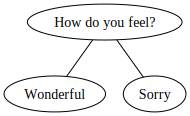

In [ ]:
graph = Graph(name='test')

node = Node(
    "How do you feel?",
    children = [
        (Edge('good'),Node('Wonderful')),
        (Edge('bad'),Node('Sorry'))
    ]
)

unpack_node(graph,node)
graph

### Graph Model

In [ ]:
class GraphModel(GraphAttributes):
    directional: bool = False
    nodes: List[Node]
    
    node_attributes: Optional[List[NodeAttributes]] = []
    edge_attributes : Optional[List[EdgeAttributes]] = []

    def create_graph(self,):
        graph_attrs = self.model_dump(
                by_alias=True,
                exclude_unset=True,
                exclude={'nodes','node_attributes','edge_attributes','directional'}
        )
        if self.directional:
            graph = Digraph(graph_attr=graph_attrs)
        else:
            graph = Graph(graph_attr=graph_attrs)
        for node in self.nodes:
            unpack_node(graph,node,self)
        return graph

In [ ]:

node = Node(
    "start",
    label='How do you feel?',
    children = [
        (Edge('good'),Node('Wonderful')),
        (Edge('bad'),Node('Sorry'))
    ]
)
graph = GraphModel(
    name="flowchart",
    nodes = [node],
    edge_attributes=[
        EdgeAttributes('good',color='green',label='Great!',pos='l'),
        EdgeAttributes('bad',color='red',label="oh well...")
    ]
)
graph

GraphModel(name='flowchart', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, background=None, bb=None, beautify=False, bgcolor=None, center=False, charset='UTF-8', clusterrank='local', compound=False, concentrate='False', Damping=0.99, defaultdist=None, dim=2, dimen=2, diredgeconstraints=False, dpi=96.0, epsilon=None, esep='+3', fontnames=None, fontpath=None, forcelabels=True, gradientangle=0, imagepath=None, inputscale=None, K=0.3, label_scheme=0, labeljust='c', labelloc='b', landscape=False, layerlistsep=',', layers=None, layout=None, levels=None, levelsgap=0.0, lp=None, margin=None, maxiter=None, nodesep=0.25, pack=False, rankdir='TB', ranksep=0.5, resolution=96.0, root=None, rotate=0, scale=None, size=None, smoothing='none', splines=None, start=None, xdotversion=None, directional=False, nodes=[Node(name='start', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label='How do you feel?', nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, area=1.0, color='black', distortion=0.0, fillcolor='lightgrey', fixedsize=False, gradientangle=0, group=None, height=0.5, image=None, imagepos='mc', imagescale=False, labelloc='c', layer=None, margin=None, ordering=None, orientation=0.0, penwidth=1.0, peripheries=None, pin=False, pos=None, rects=None, regular=False, root=False, samplepoints=None, shape='ellipse', shapefile=None, sides=4, skew=0.0, sortv=0, vertices=None, width=0.75, xlabel=None, xlp=None, z=0.0, children=[(Edge(name='good', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, arrowhead='normal', arrowsize=1.0, arrowtail='normal', color='black', constraint='True', decorate=False, dir='forward', edgehref=None, edgetarget=None, edgetooltip=None, edgeURL=None, fillcolor=None, head_lp=None, headclip=True, headhref=None, headlabel=None, headport='center', headtarget=None, headtooltip=None, headURL=None, labelangle=-25.0, labeldistance=1.0, labelfloat=False, labelfontcolor='black', labelfontname='Times-Roman', labelfontsize=14.0, labelhref=None, labeltarget=None, labeltooltip=None, labelURL=None, layer=None, len=1.0, lhead=None, lp=None, ltail=None, minlen=1, penwidth=1.0, pos=None, samehead=None, sametail=None, tail_lp=None, tailclip=True, tailhref=None, taillabel=None, tailport='center', tailtarget=None, tailtooltip=None, tailURL=None, weight=1, xlabel=None, xlp=None), Node(name='Wonderful', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, area=1.0, color='black', distortion=0.0, fillcolor='lightgrey', fixedsize=False, gradientangle=0, group=None, height=0.5, image=None, imagepos='mc', imagescale=False, labelloc='c', layer=None, margin=None, ordering=None, orientation=0.0, penwidth=1.0, peripheries=None, pin=False, pos=None, rects=None, regular=False, root=False, samplepoints=None, shape='ellipse', shapefile=None, sides=4, skew=0.0, sortv=0, vertices=None, width=0.75, xlabel=None, xlp=None, z=0.0, children=[])), (Edge(name='bad', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, arrowhead='normal', arrowsize=1.0, arrowtail='normal', color='black', constraint='True', decorate=False, dir='forward', edgehref=None, edgetarget=None, edgetooltip=None, edgeURL=None, fillcolor=None, head_lp=None, headclip=True, headhref=None, headlabel=None, headport='center', headtarget=None, headtooltip=None,

2025-09-02 15:33:30,640 - graphviz.backend.execute - DEBUG - run [PosixPath('dot'), '-Kdot', '-Tsvg']


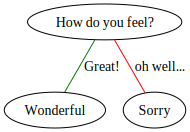

In [ ]:
graph.create_graph()

2025-09-02 15:33:30,691 - graphviz.backend.execute - DEBUG - run [PosixPath('dot'), '-Kdot', '-Tsvg']


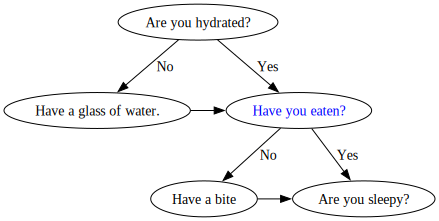

In [ ]:
no = Edge("No",label="No")
yes = Edge("Yes",label="Yes")
next_ = Edge('default')
eat = Node("Have a bite")
drink = Node("Have a glass of water.")
eaten = Node(name = "eaten",label="Have you eaten?",fontcolor='blue')
drink > (next_,eaten)
sleep = Node("Take a nap")
eat > Node("Are you sleepy?")


foul_mood_flow = Node(
    "Are you hydrated?",
    children=[
        (no,drink),
        (yes,Node(
            name='eaten',
            children=[
                (no,eat),
                (yes,Node("Are you sleepy?"))
            ]
        ))
    ]
)
graph = GraphModel(
    "foul_mood_guide",
    directional=True,
    nodes=[foul_mood_flow],
    edge_attributes=[
        Edge('default',constraint='False')
    ]
)
graph.create_graph()

In [ ]:
fund = Node('fund',label="Real Estate Owning GP, LLC",shape="rectangle",fillcolor='lightBlue',style='filled')
lp = Node(name='lp-default',shape='triangle')
gp_edge = Edge(name='gp',label = 'GP')
edge = Edge('')
lp1 = lp("LP 1")
lp2 = lp("LP 2")
lp3 = lp("LP 3")
lp4 = lp("LP 4")
fund > (gp_edge,lp1)
fund > (gp_edge,lp2)
lp2 > (gp_edge,lp3)
lp1 > lp4
agg = lp('Aggregator, LP')
lp3 > agg
lp4 > agg
reit = Node('reit',label='Reit')
agg > reit


In [ ]:
(Edge('default'),reit) in agg.children

True

GraphModel(name='corp', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, background=None, bb=None, beautify=False, bgcolor=None, center=False, charset='UTF-8', clusterrank='local', compound=False, concentrate='False', Damping=0.99, defaultdist=None, dim=2, dimen=2, diredgeconstraints=False, dpi=96.0, epsilon=None, esep='+3', fontnames=None, fontpath=None, forcelabels=True, gradientangle=0, imagepath=None, inputscale=None, K=0.3, label_scheme=0, labeljust='c', labelloc='b', landscape=False, layerlistsep=',', layers=None, layout=None, levels=None, levelsgap=0.0, lp=None, margin=None, maxiter=None, nodesep=0.25, pack=False, rankdir='TB', ranksep=0.5, resolution=96.0, root=None, rotate=0, scale=None, size=None, smoothing='none', splines=None, start=None, xdotversion=None, directional=True, nodes=[Node(name='fund', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label='Real Estate Owning GP, LLC', nojustify=False, showboxes=0, style='filled', target=None, tooltip=None, URL=None, area=1.0, color='black', distortion=0.0, fillcolor='lightBlue', fixedsize=False, gradientangle=0, group=None, height=0.5, image=None, imagepos='mc', imagescale=False, labelloc='c', layer=None, margin=None, ordering=None, orientation=0.0, penwidth=1.0, peripheries=None, pin=False, pos=None, rects=None, regular=False, root=False, samplepoints=None, shape='rectangle', shapefile=None, sides=4, skew=0.0, sortv=0, vertices=None, width=0.75, xlabel=None, xlp=None, z=0.0, children=[(EdgeAttributes(name='gp', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label='GP', nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, arrowhead='normal', arrowsize=1.0, arrowtail='normal', color='black', constraint='True', decorate=False, dir='forward', edgehref=None, edgetarget=None, edgetooltip=None, edgeURL=None, fillcolor=None, head_lp=None, headclip=True, headhref=None, headlabel=None, headport='center', headtarget=None, headtooltip=None, headURL=None, labelangle=-25.0, labeldistance=1.0, labelfloat=False, labelfontcolor='black', labelfontname='Times-Roman', labelfontsize=14.0, labelhref=None, labeltarget=None, labeltooltip=None, labelURL=None, layer=None, len=1.0, lhead=None, lp=None, ltail=None, minlen=1, penwidth=1.0, pos=None, samehead=None, sametail=None, tail_lp=None, tailclip=True, tailhref=None, taillabel=None, tailport='center', tailtarget=None, tailtooltip=None, tailURL=None, weight=1, xlabel=None, xlp=None), Node(name='LP 1', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, area=1.0, color='black', distortion=0.0, fillcolor='lightgrey', fixedsize=False, gradientangle=0, group=None, height=0.5, image=None, imagepos='mc', imagescale=False, labelloc='c', layer=None, margin=None, ordering=None, orientation=0.0, penwidth=1.0, peripheries=None, pin=False, pos=None, rects=None, regular=False, root=False, samplepoints=None, shape='triangle', shapefile=None, sides=4, skew=0.0, sortv=0, vertices=None, width=0.75, xlabel=None, xlp=None, z=0.0, children=[(EdgeAttributes(name='default', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, arrowhead='normal', arrowsize=1.0, arrowtail='normal', color='black', constraint='True', decorate=False, dir='forward', edgehref=None, edgetarget=None, edgetooltip=None, edgeURL=None, fillcolor=None, head_lp=None, headclip=True, headhref=None, headlabel=None, headport='center', headtarget=N

2025-09-02 15:33:36,116 - graphviz.backend.execute - DEBUG - run [PosixPath('dot'), '-Kdot', '-Tsvg']


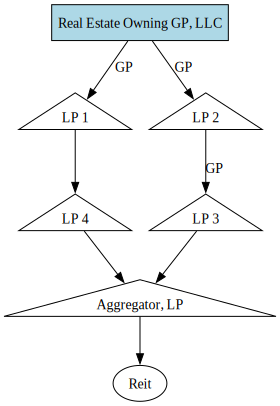

In [ ]:
corporate_structure = GraphModel(
    
    'corp',
    nodes=[fund.model_dump(exclude_defaults=True)],
    rankdir='TB',
    directional=True,
    #concentrate='True'

)

display(corporate_structure)
corporate_structure.create_graph()

In [ ]:
corporate_structure.nodes[0]

Node(name='fund', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label='Real Estate Owning GP, LLC', nojustify=False, showboxes=0, style='filled', target=None, tooltip=None, URL=None, area=1.0, color='black', distortion=0.0, fillcolor='lightBlue', fixedsize=False, gradientangle=0, group=None, height=0.5, image=None, imagepos='mc', imagescale=False, labelloc='c', layer=None, margin=None, ordering=None, orientation=0.0, penwidth=1.0, peripheries=None, pin=False, pos=None, rects=None, regular=False, root=False, samplepoints=None, shape='rectangle', shapefile=None, sides=4, skew=0.0, sortv=0, vertices=None, width=0.75, xlabel=None, xlp=None, z=0.0, children=[(EdgeAttributes(name='gp', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label='GP', nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, arrowhead='normal', arrowsize=1.0, arrowtail='normal', color='black', constraint='True', decorate=False, dir='forward', edgehref=None, edgetarget=None, edgetooltip=None, edgeURL=None, fillcolor=None, head_lp=None, headclip=True, headhref=None, headlabel=None, headport='center', headtarget=None, headtooltip=None, headURL=None, labelangle=-25.0, labeldistance=1.0, labelfloat=False, labelfontcolor='black', labelfontname='Times-Roman', labelfontsize=14.0, labelhref=None, labeltarget=None, labeltooltip=None, labelURL=None, layer=None, len=1.0, lhead=None, lp=None, ltail=None, minlen=1, penwidth=1.0, pos=None, samehead=None, sametail=None, tail_lp=None, tailclip=True, tailhref=None, taillabel=None, tailport='center', tailtarget=None, tailtooltip=None, tailURL=None, weight=1, xlabel=None, xlp=None), Node(name='LP 1', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, area=1.0, color='black', distortion=0.0, fillcolor='lightgrey', fixedsize=False, gradientangle=0, group=None, height=0.5, image=None, imagepos='mc', imagescale=False, labelloc='c', layer=None, margin=None, ordering=None, orientation=0.0, penwidth=1.0, peripheries=None, pin=False, pos=None, rects=None, regular=False, root=False, samplepoints=None, shape='triangle', shapefile=None, sides=4, skew=0.0, sortv=0, vertices=None, width=0.75, xlabel=None, xlp=None, z=0.0, children=[(EdgeAttributes(name='default', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, arrowhead='normal', arrowsize=1.0, arrowtail='normal', color='black', constraint='True', decorate=False, dir='forward', edgehref=None, edgetarget=None, edgetooltip=None, edgeURL=None, fillcolor=None, head_lp=None, headclip=True, headhref=None, headlabel=None, headport='center', headtarget=None, headtooltip=None, headURL=None, labelangle=-25.0, labeldistance=1.0, labelfloat=False, labelfontcolor='black', labelfontname='Times-Roman', labelfontsize=14.0, labelhref=None, labeltarget=None, labeltooltip=None, labelURL=None, layer=None, len=1.0, lhead=None, lp=None, ltail=None, minlen=1, penwidth=1.0, pos=None, samehead=None, sametail=None, tail_lp=None, tailclip=True, tailhref=None, taillabel=None, tailport='center', tailtarget=None, tailtooltip=None, tailURL=None, weight=1, xlabel=None, xlp=None), Node(name='LP 4', class_=None, colorscheme=None, comment=None, fontcolor='black', fontname='Times-Roman', fontsize=14.0, href=None, id=None, label=None, nojustify=False, showboxes=0, style=None, target=None, tooltip=None, URL=None, area=1.0, color='black', distortion=0.0, fillcolor='lightgrey', fixedsize=False, gradientangle=0, group=None, height=0.5, image=None, imagepos='mc', imagescale=False, labelloc='c', layer=None, margin=None, ordering=None, ori